# Confidence interval quantification using MCMCSim

`MCMCSim` is a auxialiry tool using `emcee` library to make it ease to perform MCMC uncertainty quantification.

The goal is only to provide auxiliary functionalities that are common for uncertainty quantification using MCMC. The core MCMC is performed by `emcee`.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lmfit
import mcmcsim
from IPython.display import display, Math
%load_ext autoreload
%autoreload 2


## Model Function 

The function should receive a `lmfit.Parameters` object or a regular python dictionary:

```
p = {
    'param_name1': value1,
    'param_name2': value2,
}
```

The `inputs_dict` is also a dicionary: `{input_name: Variable}`. To allow passing additional parameters related with the input, the input is a `mcmcsim.Variable`. Which has a field values and a field sigma, for instance.



In [2]:
def calc_model_new(p, inputs_dict, extra_arg_kw=None):
    v = extra_arg_kw
    x = inputs_dict['x'].values
    y1 = p['a1']*np.exp(-x/p['t1'])
    y2 = p['a2']*np.exp(-(x-0.1)/p['t2'])
    return {
        'y1': y1,
        'y2': y2,
    }

## Creating parameters and generating fake experimental data

In [3]:
p_true = lmfit.Parameters()
p_true.add('a1', value=3.0)
p_true.add('a2', value=-5.)
p_true.add('t1', value=2.)
p_true.add('t2', value=10.)
sigma = np.array([0.1, 0.5])

num_out = len(sigma)
sigma2 = sigma**2
x = np.linspace(1, 10, 250)

inputs_dict = {
    'x': mcmcsim.Variable('x', x),
}

error_y = sigma*np.random.randn(x.size, num_out)
y_true_dict = calc_model_new(p_true, inputs_dict)
y_true = np.column_stack([v for v in y_true_dict.values()])
y_exp = y_true + error_y

"Using the dict approach for experimental data and inputs"
y_exp_dict = {
    'y1': mcmcsim.Variable('y1', y_exp[:,0], sigma[0]),
    'y2': mcmcsim.Variable('y1', y_exp[:,1], sigma[1])
}

Viewing the outputs

Text(0, 0.5, 'y1; y2')

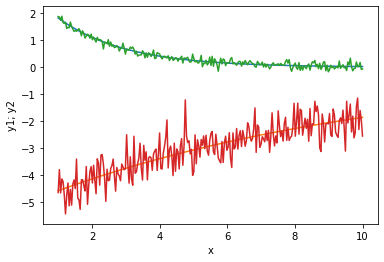

In [4]:
plt.figure()
plt.plot(x, y_true)
plt.plot(x, y_exp)
plt.xlabel('x')
plt.ylabel('y1; y2')

## Setting up initial guess parameter

In [5]:
params0 = lmfit.Parameters()
params0.add('a1', 4.0, min=-10.0, max=10.0)
params0.add('a2', 4.0, min=-10.0, max=10.0)
params0.add('t1', 3.0, min=-10.0, max=10.0)
params0.add('t2', 8.0, min=-10.0, max=20.0)

## Creating the MCMCRunner object.

This is the main class to run a MCMC case

In [6]:
runner = mcmcsim.MCMCRunner(calc_model_new, params0, y_exp_dict, inputs_dict,
    fpath='output_mcmcs.h5', store_outputs=True, store_params_exp_and_inputs=True,
)

## Regular parameter estimation

Before running MCMC is advisable to provide a value close to the optimal

In [7]:
"Calculating the (-) log likelihood"
f_ls = runner.calc_minus_loglikelihood(params0)
print(f_ls)

"Regular parameter estimation (using lmfit)"
mini = lmfit.Minimizer(runner.calc_minus_loglikelihood, params0, nan_policy='propagate')

out1 = mini.minimize(method='Nelder') #'differential_evolution'
lmfit.report_fit(out1)
params_f = out1.params

"Updating reference parameter in Runner (idealy, it will be passed in the constructor)"
runner.set_parameters_ref(params_f)

18673.1566642504
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 290
    # data points      = 1
    # variables        = 4
    chi-square         = 2474.75483
    reduced chi-square = 2474.75483
    Akaike info crit   = 15.8138966
    Bayesian info crit = 7.81389661
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a1:  2.94419511 (init = 4)
    a2: -4.98797826 (init = 4)
    t1:  2.01921201 (init = 3)
    t2:  10.0033174 (init = 8)


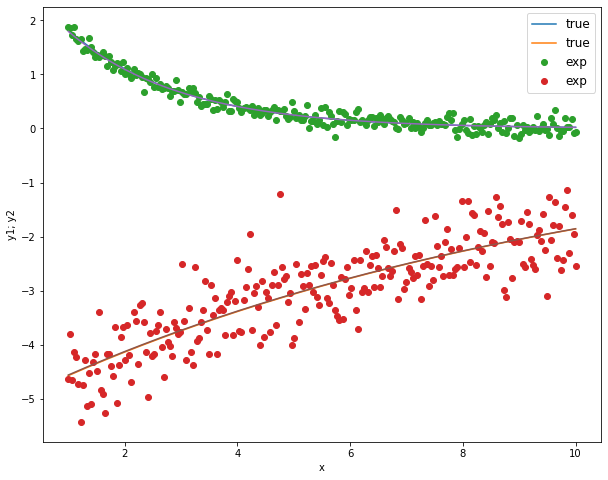

In [8]:
"Calculating the outputs using the estimated parameters"
y_out_optimal = calc_model_new(params_f, inputs_dict)

"View"
plt.figure(figsize=(10,8))
plt.plot(x, y_true, label='true')
plt.plot(x, y_exp, 'o', label='exp')
plt.plot(x, y_out_optimal['y1'])
plt.plot(x, y_out_optimal['y2'])
plt.legend(fontsize=12)
plt.xlabel('x')
plt.ylabel('y1; y2')
plt.show()


## Running MCMC - From scratch.

100%|██████████| 100/100 [00:00<00:00, 112.07it/s]


Final size: 100


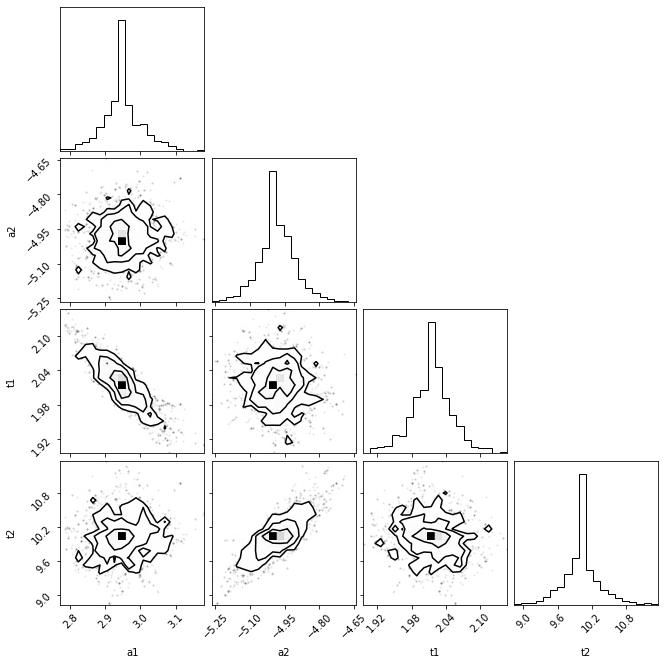

In [9]:
runner.run_mcmc(load_backend=False, nsteps=100, progress=True)

runner.plot_corner();

Note that there are not enough points. Therefore, we need to run more sampling.

Initial size: 100


100%|██████████| 500/500 [00:04<00:00, 120.56it/s]


Final size: 600


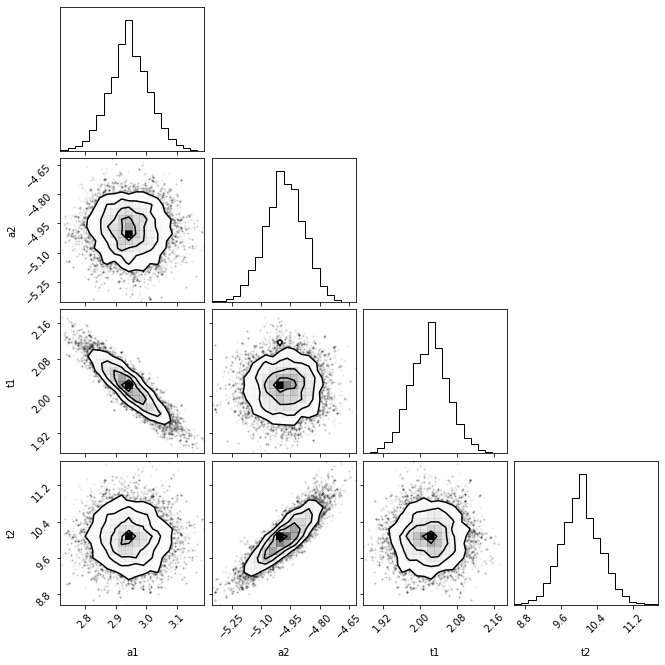

In [10]:
runner.run_mcmc(load_backend=True, nsteps=500, progress=True)

runner.plot_corner();


We can view the sample history:

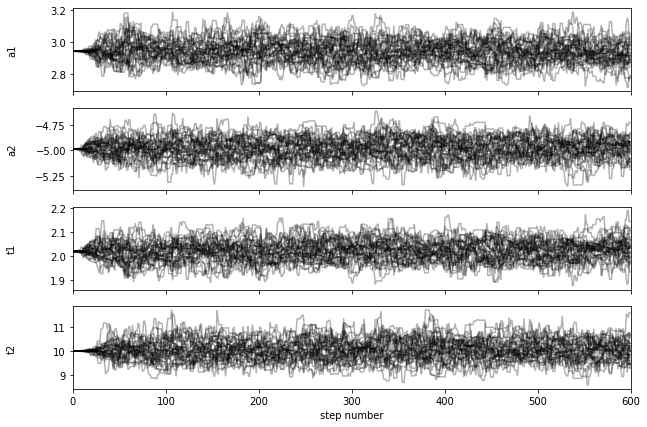

In [11]:
runner.plot_chain()

Additonaly, we can plot the outputs to visualize the errors compared with the experimental data. For that, the option `store_outputs=True` is required in `MCMCRunner`.

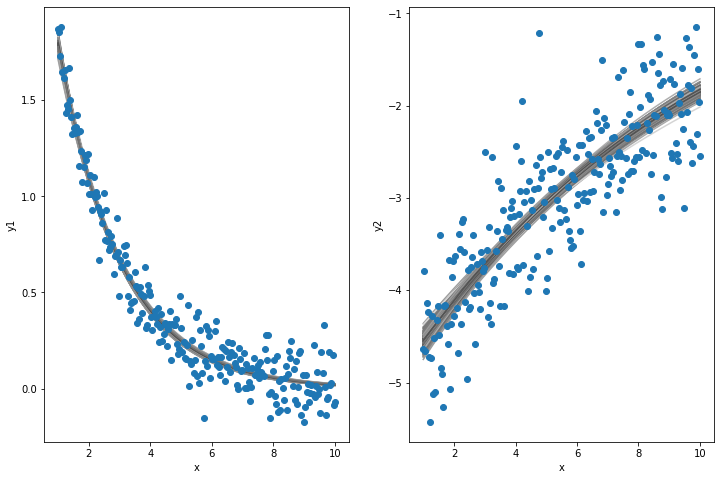

In [12]:
runner.plot_mcmc_outputs(thin=100, save_no_show=False);

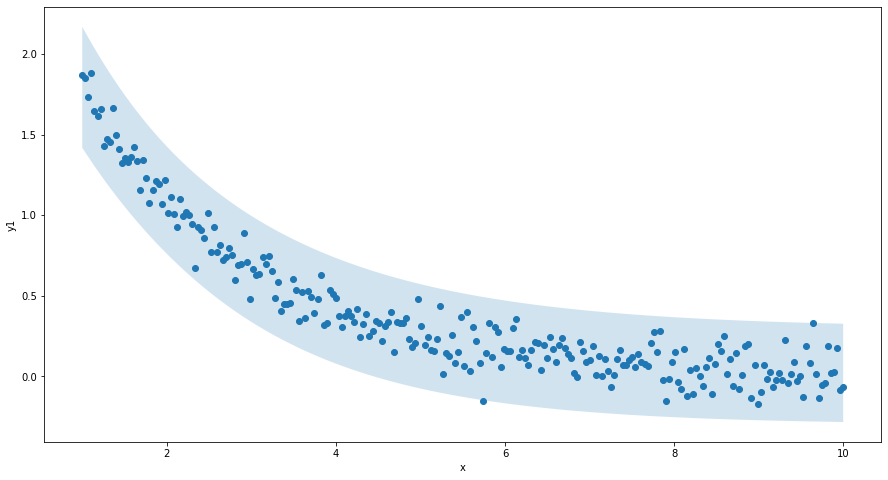

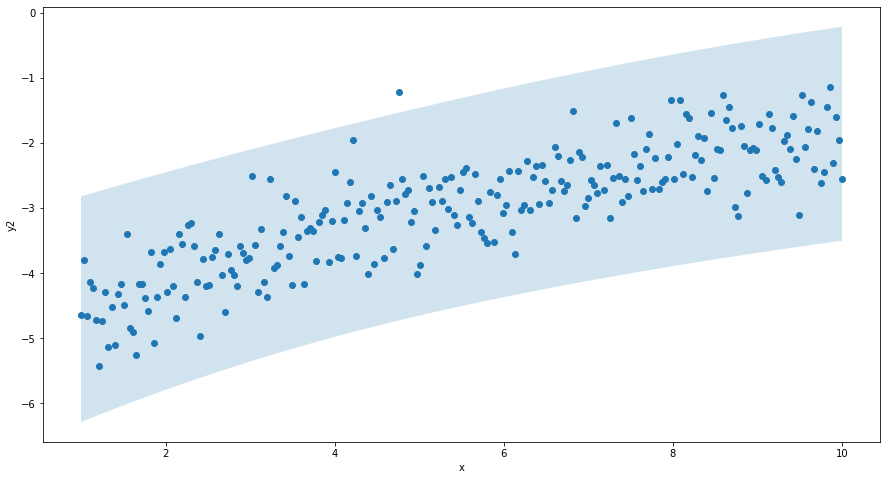

In [13]:
runner.plot_predictions()

The generate figure can get too heavy. Therefore, it may me better to save the figure to file using `save_no_show=True`

One can also get the interval from the margnilized distribution.

In [14]:
params_intervals = runner.get_parameter_interval_from_marginalized(latex_formated=True)
latexes = [item['latex'] for item in params_intervals.values()]
[display(Math(txt)) for txt in latexes];

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Loading Runner from file

Suppose we are running a long sampling and we need to stop running. We can reinitialize from a file using `emcee` backends.

### Loading only for plotting

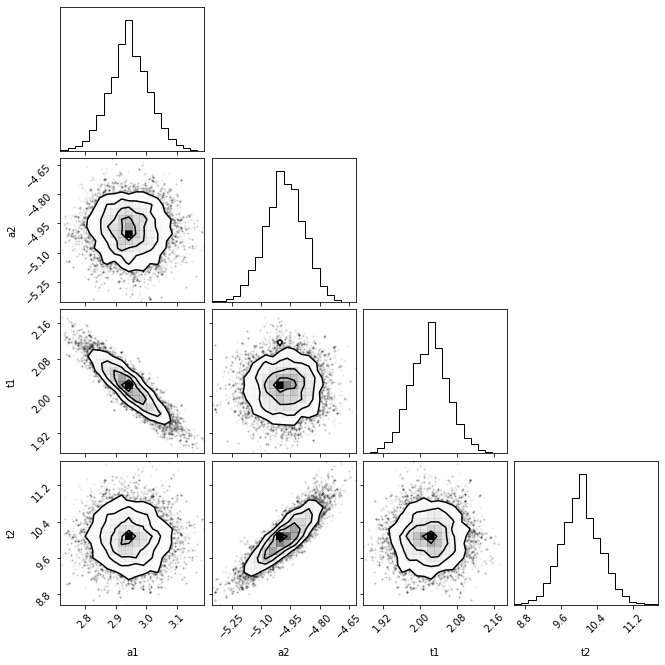

In [15]:
runner = mcmcsim.MCMCRunner(fpath='output_mcmcs.h5', initialize_from_h5=True)

runner.plot_corner();

### Loading for continue to sample

Just passing the function we can continue the sampling procedure.

Initial size: 600


100%|██████████| 100/100 [00:00<00:00, 115.68it/s]


Final size: 700


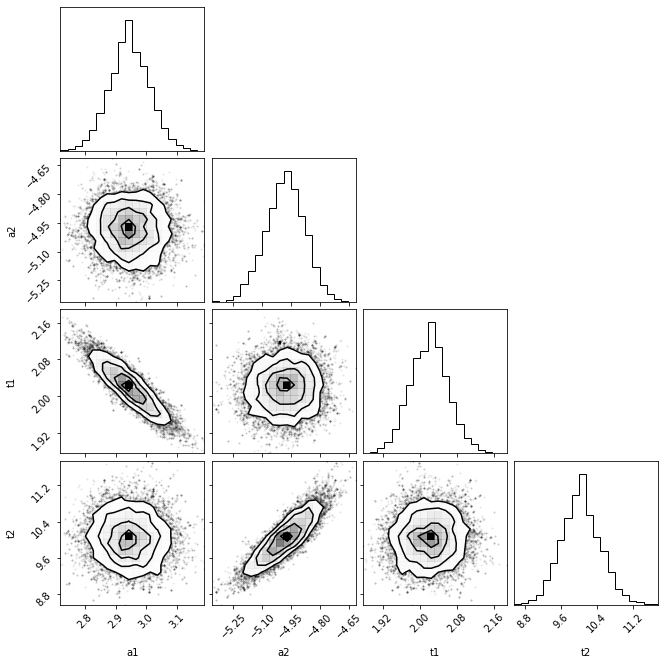

In [16]:
runner = mcmcsim.MCMCRunner(calc_model_new, fpath='output_mcmcs.h5',
    initialize_from_h5=True, store_outputs=True)

runner.run_mcmc(load_backend=True, nsteps=100, progress=True)

runner.plot_corner();

- The sampling can also be reinitilized passing the parameters as in the initialization
- The reinitilization should be run with care. If `load_backend=False`  it will reset the sampling history. Therefore, backup copies are important.

## Removing parameters and outputs

Parameters not considering in a sampling run can be removed by setting the field `vary=False`. This is also true for the output, that is, to not include a particular output in the posterior quantification.

100%|██████████| 2000/2000 [00:28<00:00, 69.74it/s]


Final size: 2000


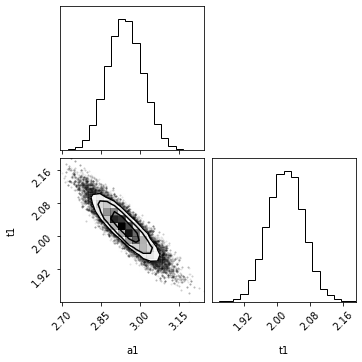

In [17]:

"Using the dict approach for experimental data and inputs"
y_exp_dict = {
    'y1': mcmcsim.Variable('y1', y_exp[:,0], sigma[0]),
    'y2': mcmcsim.Variable('y2', y_exp[:,1], sigma[1], vary=False)
}

params0 = lmfit.Parameters()
params0.add('a1', 2.944542, min=-10.0, max=10.0)
params0.add('a2', -4.98801, min=-10.0, max=10.0, vary=False)
params0.add('t1', 2.019002, min=-10.0, max=10.0)
params0.add('t2', 10.0, min=-10.0, max=20.0, vary=False)

runner = mcmcsim.MCMCRunner(calc_model_new, params0, y_exp_dict, inputs_dict,
    fpath='output_mcmcs.h5', store_outputs=True, store_params_exp_and_inputs=True,
)

runner.run_mcmc(load_backend=False, nsteps=2000, progress=True)

runner.plot_corner(discard=300);

